In [133]:
import os,re,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2019)
import xgboost as xgb
import lightgbm as lgb
#import catboost as ctb
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
#from catboost import Pool, CatBoostClassifier
from category_encoders import TargetEncoder
from scipy.special import logit

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

%matplotlib inline


In [134]:
os.chdir('D:/hackathon/crowdanalytics/logfacies/')

In [135]:
os.listdir()

['CAX_LogFacies_DataDescription.docx',
 'CAX_LogFacies_Submission_File.csv',
 'CAX_LogFacies_Test_File.csv',
 'CAX_LogFacies_Train_File.csv',
 'crowdanalytics_logfacie.ipynb',
 'errorfiles_camangle.txt',
 'errorfiles_camangle2.txt',
 'errorfiles_camangle3.txt',
 'featurexgb.txt',
 'lshw.html',
 'Slaughter+and+May+-+FINAL+REPORT+FOR+PUBLICATION.pdf',
 'sub1.csv',
 'sub2.csv',
 'sub_xgb1.csv',
 'sub_xgb2.csv',
 'testdata_total.csv',
 'totaldata_model.csv',
 'totallog.txt',
 'traindata_scaled.csv',
 'vocab.txt']

In [137]:
trainf=pd.read_csv('CAX_LogFacies_Train_File.csv')
testf=pd.read_csv('CAX_LogFacies_Test_File.csv')

In [81]:
samplsub=pd.read_csv('CAX_LogFacies_Submission_File.csv')

In [138]:
trainf.head()

,row_id,well_id,GR,label
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0


In [139]:
X_train = pd.pivot_table(trainf, values='GR', index=['well_id'], columns=['row_id'])


In [140]:
X_train.head()

row_id,0,1,2,3,4,5,6,7,8,9,...,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099
well_id,,,,,,,,,,,,,,,,,,,,,
0,143.51,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,...,142.881647,137.732575,145.843503,133.434431,144.205359,139.136288,158.257216,139.508144,130.589072,154.93
1,122.26,112.872757,120.125514,122.488271,132.111028,117.603785,117.206542,114.179299,115.182056,118.134813,...,150.295187,150.337944,133.380701,155.813458,159.656215,158.788972,139.421729,157.724486,159.127243,137.45
2,125.94,121.713658,112.027316,115.600974,129.104631,111.938289,132.901947,110.015605,118.769263,108.452921,...,137.417079,150.210737,152.374395,143.668053,136.331711,134.055369,148.719026,153.752684,134.256342,151.32
3,109.03,122.551838,122.963676,113.355514,115.347352,124.439190,118.081028,133.792866,120.034704,104.266542,...,150.073458,156.795296,149.217134,144.178972,135.520810,139.422648,156.184486,143.236324,125.958162,149.23
4,109.01,132.092739,111.845478,105.268217,115.480955,110.033694,130.016433,117.889172,113.621911,108.794650,...,150.875350,121.358089,139.830828,130.123567,143.416306,138.229045,121.911783,137.074522,124.117261,133.20


In [110]:
q=trainf[['GR','label']]
trainf['100gr']=trainf['GR']*100
period2 = trainf['100gr'].diff(2) 
trainf['100grdiff']=period2


In [111]:
trainf.head()

,row_id,well_id,GR,label,100gr,100grdiff
0,0,0,143.510000,0,14351.000000,NaN
1,1,0,112.790928,0,11279.092812,NaN
2,2,0,123.531856,0,12353.185623,-1997.814377
3,3,0,111.692784,0,11169.278435,-109.814377
4,4,0,123.613712,0,12361.371247,8.185623


In [106]:
q.groupby(['label']).agg([np.mean,np.median])

GR                     100gr                 100grdiff  \
             mean      median          mean        median        mean   
label                                                                   
0      132.141165  131.487452  13214.116547  13148.745223   95.074721   
1       82.115153   77.816486   8211.515271   7781.648626   33.247116   
2       57.847181   57.706214   5784.718065   5770.621368 -279.909038   
3       97.837936   99.522948   9783.793591   9952.294800   58.417563   
4       98.146792   99.838880   9814.679243   9983.887970 -232.783371   

                   
           median  
label              
0       25.639672  
1       36.708363  
2      -74.000000  
3      230.440972  
4     -271.000000

In [9]:
testf.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [10]:
samplsub.head()

,unique_id,label
0,CAX_0,NaN
1,CAX_1,NaN
2,CAX_2,NaN
3,CAX_3,NaN
4,CAX_4,NaN


In [11]:
trainf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400000 entries, 0 to 4399999
Data columns (total 4 columns):
row_id     int64
well_id    int64
GR         float64
label      int64
dtypes: float64(1), int64(3)
memory usage: 134.3 MB


In [12]:
trainf['label'].value_counts()/len(trainf)

0    0.525746
2    0.119404
3    0.118668
1    0.118351
4    0.117832
Name: label, dtype: float64

In [13]:
trainf[['GR']].describe()

,GR
count,4.400000e+06
mean,1.092733e+02
std,3.424240e+01
min,-3.181915e+00
25%,8.179222e+01
50%,1.203849e+02
75%,1.347291e+02
max,1.970614e+02


In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import numpy as np


scaler = MinMaxScaler()
trainf['GR_scaled'] = scaler.fit_transform(trainf[['GR']])


In [69]:

scaler = MinMaxScaler()
testf['GR_scaled'] = scaler.fit_transform(testf[['GR']])


In [70]:
testf.head()

,unique_id,row_id,well_id,GR,GR_scaled
0,CAX_0,0,5000,113.950000,0.591148
1,CAX_1,1,5000,120.896397,0.625690
2,CAX_2,2,5000,115.342793,0.598074
3,CAX_3,3,5000,118.859190,0.615560
4,CAX_4,4,5000,127.735587,0.659700


In [15]:
#plt.hist(np.log(trainf['GR_scaled'].values))

In [16]:
def log_transform(x):
    return np.log(x +1) 

trainf['GR_scaled']=trainf['GR_scaled'].apply(lambda x : log_transform(x))

In [17]:
trainf.isna().sum()

row_id       0
well_id      0
GR           0
label        0
GR_scaled    0
dtype: int64

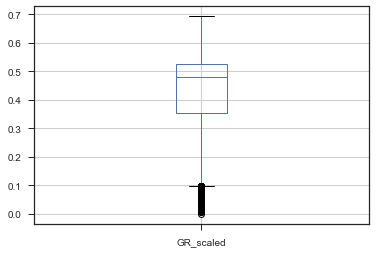

In [18]:
trainf[['GR_scaled']].boxplot()

In [19]:
def loggama_plot(df,wellid):
    df_1=df[df['well_id']==wellid]
    df_1.index=df_1['row_id']
    return df_1[['GR_scaled']].plot()

In [20]:
# for i in range(10):
#     loggama_plot(trainf,i)

In [21]:
df_2=trainf[trainf['well_id']==0]
#df_2[df_2['label']==2].shape
df_2['GR_2']=df_2['GR'].apply(lambda x : abs(df_2['GR'].mean()-x))
df_2[['label','GR_2']].groupby(['label']).agg([np.mean,np.median,np.max,np.min]),df_2[['GR']].mean()

C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(            GR_2                                 
             mean     median       amax       amin
 label                                            
 0      18.996606  17.776922  56.937818   0.013723
 1      31.166428  30.312484  83.097284   0.961250
 2      48.882379  48.091487  88.602711  15.144315
 3      23.086040  20.158025  64.452225   1.254225
 4      26.014328  24.160488  70.364996   0.375048, GR    110.6916
 dtype: float64)

In [22]:
# df_2=trainf[trainf['well_id']==10]
# #df_2[df_2['label']==2].shape
# df_2['GR_2']=df_2['GR'].apply(lambda x : abs(df_2['GR'].mean()-x))
# df_2[['label','GR_2']].groupby(['label']).agg([np.mean,np.median,np.max,np.min]),df_2[['GR']].mean()

In [23]:
df_2=trainf[trainf['well_id'].isin([0,1])]
df_2.head()

,row_id,well_id,GR,label,GR_scaled
0,0,0,143.510000,0,0.549605
1,1,0,112.790928,0,0.456893
2,2,0,123.531856,0,0.490296
3,3,0,111.692784,0,0.453414
4,4,0,123.613712,0,0.490546


In [27]:
df_2=trainf.copy()

In [28]:
ct_Data=df_2[['well_id','GR']].groupby(['well_id']).agg([np.mean,np.median])
ct_Data.columns = ct_Data.columns.map('_'.join) # Collapse the multiindex into one level
ct_Data.reset_index(inplace = True) # Add ad file name as a column
ct_Data.head()

,well_id,GR_mean,GR_median
0,0,110.691600,120.972610
1,1,112.855551,121.264641
2,2,114.627655,125.805864
3,3,105.594707,117.275410
4,4,104.178025,117.548529


In [71]:
df_2_test=testf.copy()
ct_Data_test=df_2_test[['well_id','GR']].groupby(['well_id']).agg([np.mean,np.median])
ct_Data_test.columns = ct_Data_test.columns.map('_'.join) # Collapse the multiindex into one level
ct_Data_test.reset_index(inplace = True) # Add ad file name as a column
ct_Data_test.head()

,well_id,GR_mean,GR_median
0,5000,124.024787,133.298826
1,5001,120.721828,129.993942
2,5002,108.399849,118.407138
3,5003,104.874753,121.494836
4,5004,93.058905,107.439487


In [72]:
df_2_test=df_2_test.merge(ct_Data_test,on='well_id',how='left')
df_2_test['C'] = df_2_test.groupby(['well_id']).cumcount();


,well_id,GR_mean,GR_median
0,5000,124.024787,133.298826
1,5001,120.721828,129.993942
2,5002,108.399849,118.407138
3,5003,104.874753,121.494836
4,5004,93.058905,107.439487


In [73]:
df_2_test.head()

,unique_id,row_id,well_id,GR,GR_scaled,GR_mean,GR_median,C
0,CAX_0,0,5000,113.950000,0.591148,124.024787,133.298826,0
1,CAX_1,1,5000,120.896397,0.625690,124.024787,133.298826,1
2,CAX_2,2,5000,115.342793,0.598074,124.024787,133.298826,2
3,CAX_3,3,5000,118.859190,0.615560,124.024787,133.298826,3
4,CAX_4,4,5000,127.735587,0.659700,124.024787,133.298826,4


In [29]:
df_2=df_2.merge(ct_Data,on='well_id',how='left')

In [30]:
df_2['C'] = df_2.groupby(['well_id']).cumcount();

In [31]:
4**2

16

In [32]:
## new feature creation

# G - relative center of gravity
n=1100
def G(gr,ind):
    #print(int(ind))
    ind= ind + 1
    num=0
    f=0
    for i in range(1,int(ind)+1):
        #print('value of i is {}'.format(i))
        num = num + i*gr
        f = f + gr
    #print('value of f is {}'.format(f))
    #print('value of s is {}'.format(s))
    f2=n*f       
    return num/f2

# S - variance of log amplitude

def S(gr,mean):
    (gr-mean)**2
     

In [33]:
df_2['g']=df_2.apply(lambda x : G(x['GR'],x['C']),axis = 1)

In [74]:
df_2_test['g']=df_2_test.apply(lambda x : G(x['GR'],x['C']),axis = 1)

In [75]:
df_2_test.head().head()

,unique_id,row_id,well_id,GR,GR_scaled,GR_mean,GR_median,C,g
0,CAX_0,0,5000,113.950000,0.591148,124.024787,133.298826,0,0.000909
1,CAX_1,1,5000,120.896397,0.625690,124.024787,133.298826,1,0.001364
2,CAX_2,2,5000,115.342793,0.598074,124.024787,133.298826,2,0.001818
3,CAX_3,3,5000,118.859190,0.615560,124.024787,133.298826,3,0.002273
4,CAX_4,4,5000,127.735587,0.659700,124.024787,133.298826,4,0.002727


In [76]:
df_2_test.to_csv("D:/hackathon/crowdanalytics/logfacies/testdata_total.csv",index=None)

In [34]:
def range2(x, axis=0):
    return np.max(x, axis=axis) - np.min(x, axis=axis)


range2(df_2['g'].values)


0.4995454545454688

In [35]:
np.max(df_2['g'].values),np.min(df_2['g'].values)

(0.5004545454545597, 0.000909090909090909)

In [37]:
trainf=df_2.copy()

In [113]:
trainf.describe()

,row_id,well_id,GR,label,100gr,100grdiff,GR_scaled
count,4.400000e+06,4.400000e+06,4.400000e+06,4.400000e+06,4.400000e+06,4.399998e+06,4.400000e+06
mean,5.495000e+02,1.999500e+03,1.092733e+02,1.184489e+00,1.092733e+04,8.212805e-04,5.615926e-01
std,3.175426e+02,1.154701e+03,3.424240e+01,1.465016e+00,3.424240e+03,1.782347e+03,1.710039e-01
min,0.000000e+00,0.000000e+00,-3.181915e+00,0.000000e+00,-3.181915e+02,-1.507279e+04,0.000000e+00
25%,2.747500e+02,9.997500e+02,8.179222e+01,0.000000e+00,8.179222e+03,-9.990000e+02,4.243544e-01
50%,5.495000e+02,1.999500e+03,1.203849e+02,0.000000e+00,1.203849e+04,4.181271e+00,6.170835e-01
75%,8.242500e+02,2.999250e+03,1.347291e+02,2.000000e+00,1.347291e+04,1.003915e+03,6.887169e-01
max,1.099000e+03,3.999000e+03,1.970614e+02,4.000000e+00,1.970614e+04,1.572922e+04,1.000000e+00


In [39]:
summarydata=trainf[['well_id','row_id']].groupby(['well_id']).agg([np.count_nonzero])
summarydata.columns = summarydata.columns.map('_'.join) # Collapse the multiindex into one level
summarydata.reset_index(inplace = True) # Add ad file name as a column
summarydata['row_id_count_nonzero'].unique()

array([1099], dtype=int64)

In [46]:
def GR_spread(df):
    finallist=[]
    #finaldf=pd.DataFrame(index=range(len(df)),columns=df.columns +['GR_2'])
    
    for wellid in df['well_id'].unique():
        df_2=trainf[trainf['well_id']==wellid]
        df_2['GR_2']=df_2['GR_scaled'].apply(lambda x : abs(df_2['GR_scaled'].mean()-x)/np.std(df_2['GR_scaled'].values))
        #df_2['GR_2']=df_2['GR_2'].apply(lambda x : log_transform(x))

        finallist.append(df_2.to_dict())
        
    return finallist

finaldf=GR_spread(trainf)
o=pd.concat((pd.DataFrame(f) for f in finaldf))

C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [114]:
o=trainf.copy()

In [115]:
#o=pd.concat((pd.DataFrame(f) for f in finaldf))

In [116]:
o.shape,trainf.shape

((4400000, 7), (4400000, 7))

In [117]:
o.head()

,row_id,well_id,GR,label,100gr,100grdiff,GR_scaled
0,0,0,143.510000,0,14351.000000,NaN,0.732568
1,1,0,112.790928,0,11279.092812,NaN,0.579160
2,2,0,123.531856,0,12353.185623,-1997.814377,0.632799
3,3,0,111.692784,0,11169.278435,-109.814377,0.573676
4,4,0,123.613712,0,12361.371247,8.185623,0.633208


In [50]:
o[['label','GR_2']].groupby(['label']).agg([np.mean,np.median,np.max,np.min])

GR_2                                  
           mean    median      amax          amin
label                                            
0      0.674423  0.676317  2.214978  1.071260e-06
1      1.024482  0.943726  4.491515  5.947428e-07
2      1.462095  1.444213  4.409632  3.948213e-05
3      0.787790  0.654393  4.326985  9.919529e-07
4      0.786171  0.656459  4.397111  1.062333e-06

In [51]:
o2=o[o['well_id']==0]

In [41]:
totaldf=pd.DataFrame()
for wellid in o['well_id'].unique():
    o2=o[o['well_id']==wellid]
    for i in range(1,11):
        d=o2[['GR_2']].shift(i)
        d.columns=['GR_2_lag{}'.format(i)]
        o2=pd.concat([o2,d], axis=1)
    totaldf=totaldf.append(o2)


In [39]:
for i in range(1,11):
    d=o2[['GR_2']].shift(i)
    d.columns=['GR_2_lag{}'.format(i)]
    o2=pd.concat([o2,d], axis=1)


In [42]:
totaldf.shape

(4400000, 16)

In [43]:
totaldf.head()

,row_id,well_id,GR,label,GR_scaled,GR_2,GR_2_lag1,GR_2_lag2,GR_2_lag3,GR_2_lag4,GR_2_lag5,GR_2_lag6,GR_2_lag7,GR_2_lag8,GR_2_lag9,GR_2_lag10
0,0,0,143.510000,0,0.549605,0.714255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,112.790928,0,0.456893,0.064567,0.714255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,123.531856,0,0.490296,0.342131,0.064567,0.714255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,111.692784,0,0.453414,0.031313,0.342131,0.064567,0.714255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,123.613712,0,0.490546,0.343976,0.031313,0.342131,0.064567,0.714255,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#o.to_csv("traindata_scaled.csv",index=None)

In [231]:
#trainf[['well_id','row_id']].groupby(['well_id']).agg(np.count_nonzero).reset_index()['row_id'].unique()

In [159]:
#GR_scaled=trainf[trainf['well_id']==0].T.loc['GR_scaled'].values

In [229]:
#len(trainf['well_id'].unique())

In [230]:
#GR_scaled.shape

In [189]:
# def data_trandform(df):
#     finallist=[]
#     #finaldf=pd.DataFrame(index=range(len(df)),columns=df.columns +['GR_2'])
#     dfempty={}
#     for wellid in df['well_id'].unique():
#         #df_2=trainf[trainf['well_id']==wellid]
#         GR_scaled=trainf[trainf['well_id']==wellid].T.loc['GR_scaled'].values
#         dfempty[wellid]=GR_scaled
        

#     finallist.append(dfempty)
        
#     return finallist,dfempty

# finaldf2,dfempty=data_trandform(trainf)
# #o2=pd.concat((pd.DataFrame(f) for f in finaldf2))

# e=pd.DataFrame.from_dict(dfempty,orient='index')
# coln=['row_id_' + str(i) for i in range(e.shape[1])]
# e.columns=coln
# wells=['well_id_' + str(i) for i in range(e.shape[0])]
# e['wells']=wells

In [119]:
o.head()

,row_id,well_id,GR,label,100gr,100grdiff,GR_scaled
0,0,0,143.510000,0,14351.000000,NaN,0.732568
1,1,0,112.790928,0,11279.092812,NaN,0.579160
2,2,0,123.531856,0,12353.185623,-1997.814377,0.632799
3,3,0,111.692784,0,11169.278435,-109.814377,0.573676
4,4,0,123.613712,0,12361.371247,8.185623,0.633208


In [52]:
o['label'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [118]:
totaldf=o.copy()

In [67]:
totaldf.to_csv("D:/hackathon/crowdanalytics/logfacies/totaldata_model.csv",index=None)

In [129]:
colneeded=[f for f in totaldf.columns if f not in ['well_id','GR_2','GR_scaled','GR']]
## for final test
x_train, x_valid, y_train, y_valid = train_test_split(totaldf[colneeded], totaldf['label'],
                                         test_size=0.1, random_state=42, stratify=totaldf['label'],shuffle=True)

x, x_test, y, y_test = train_test_split(x_train, x_train['label'],
                                         test_size=0.2, random_state=42, stratify=x_train['label'],shuffle=True)

print(x.shape,x_test.shape)


parameters = {
    #     'application': 'binary',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting': 'dart',
        'num_class':5,
        'num_leaves': 70,
        'max_depth': 10,'is_unbalance':True,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 10,
        'learning_rate': 0.05,'xgboost_dart_mode':True,
        'lambda_l2': 0.5,
        'verbose': 1}

def lgbmodel(dev_X, dev_y, val_X, val_y, test, params2):
    
    train_data = lgb.Dataset(dev_X, label=dev_y)
    test_data = lgb.Dataset(val_X, label=val_y)

   
    model = lgb.train(parameters,
                           train_data,
                           valid_sets=test_data,
                           num_boost_round=100,
                           early_stopping_rounds=10)
    feature_im = model.feature_importance()
    
    print('Predict 1/2')
    pred_test_y = model.predict(val_X).argmax(axis=1)
    print('len of pred_test_y is {}'.format(pred_test_y.shape))
    print('Predict 2/2')
    pred_test_y2 = model.predict(test).argmax(axis=1)
    print('len of pred_test_y2 is {}'.format(pred_test_y2.shape))
    return pred_test_y, pred_test_y2, feature_im,model


    
    from sklearn.metrics import log_loss

def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None,label='model', n_folds=5):
    kf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 228)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test.columns
    i = 1
    for dev_index, val_index in fold_splits:
        print('-------------------------------------------')
        print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
        dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
        dev_y, val_y = target.iloc[dev_index], target.iloc[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, fi,model = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        feature_importances[f'fold_{i}'] = fi
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        #if eval_fn is not None:
            #cv_score = eval_fn(val_y, pred_val_y)
        try:
            print(val_y.shape)
            print(pred_val_y.shape)
            print('f1 score is {}'.format(f1_score(val_y, pred_val_y, average='micro') ))
            cv_score=f1_score(val_y, pred_val_y, average='micro')
            print('cvscore is {}'.format(cv_score))
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score), '\n')
        except:
            print('in loop number {}'.format(i))
            
            break
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / n_folds
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores, 'fi': feature_importances}
    return results,model


# Use some baseline parameters
cat_params = {'loss_function': 'MultiClass',  # CrossEntropy
              'eval_metric': "MultiClass", #multi_logloss
              'learning_rate': 0.01,
              'classes_count' : 5,
              'iterations': 10000,
              'random_seed': 42,
              'od_type': "Iter",
              'early_stopping_rounds': 150,
             }


colneeded2=[f for f in totaldf.columns if f not in ['label','well_id','GR_2','GR_scaled','GR']]


(3168000, 4) (792000, 4)


In [130]:
colneeded2

['row_id', '100gr', '100grdiff']

In [131]:
x[colneeded2].head()

,row_id,100gr,100grdiff
3310057,157,7910.276093,883.00000
3286769,1069,13493.972702,976.00182
1379947,547,10921.292230,-628.00000
1087633,833,10428.816776,-1602.00000
2171082,782,9889.832190,-1728.00000


In [132]:
n_folds = 10
results,model = run_cv_model(x[colneeded2], x_test[colneeded2], x['label'], lgbmodel, parameters,f1_score, 'f1', n_folds=n_folds)


-------------------------------------------
Started f1 fold 1/10
[1]	valid_0's multi_logloss: 1.33501


C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's multi_logloss: 1.30819
[3]	valid_0's multi_logloss: 1.28235
[4]	valid_0's multi_logloss: 1.27629
[5]	valid_0's multi_logloss: 1.25279
[6]	valid_0's multi_logloss: 1.2385
[7]	valid_0's multi_logloss: 1.2188
[8]	valid_0's multi_logloss: 1.20962
[9]	valid_0's multi_logloss: 1.19108
[10]	valid_0's multi_logloss: 1.1845
[11]	valid_0's multi_logloss: 1.1673
[12]	valid_0's multi_logloss: 1.16578
[13]	valid_0's multi_logloss: 1.15387
[14]	valid_0's multi_logloss: 1.13896
[15]	valid_0's multi_logloss: 1.12426
[16]	valid_0's multi_logloss: 1.11759
[17]	valid_0's multi_logloss: 1.10395
[18]	valid_0's multi_logloss: 1.0974
[19]	valid_0's multi_logloss: 1.08844
[20]	valid_0's multi_logloss: 1.07823
[21]	valid_0's multi_logloss: 1.07326
[22]	valid_0's multi_logloss: 1.07062
[23]	valid_0's multi_logloss: 1.06575
[24]	valid_0's multi_logloss: 1.05549
[25]	valid_0's multi_logloss: 1.05106
[26]	valid_0's multi_logloss: 1.04268
[27]	valid_0's multi_logloss: 1.0333
[28]	valid_0's multi_loglo

KeyboardInterrupt: 

In [46]:
predv=model.predict(x_valid[colneeded2])

In [47]:
predv2=predv.argmax(axis=1)

In [48]:
f1_score(y_valid, predv2, average='micro') 

0.6334136363636363

In [22]:
testf.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [23]:
def GR_spread(df):
    finallist=[]
    #finaldf=pd.DataFrame(index=range(len(df)),columns=df.columns +['GR_2'])
    
    for wellid in df['well_id'].unique():
        df_2=df[df['well_id']==wellid]
        df_2['GR_2']=df_2['GR'].apply(lambda x : abs(df_2['GR'].mean()-x))

        finallist.append(df_2.to_dict())
        
    return finallist

finaldf2=GR_spread(testf)
testf2=pd.concat((pd.DataFrame(f) for f in finaldf2))

C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [125]:
#testf.head()

In [24]:
testf2.head()

,unique_id,row_id,well_id,GR,GR_2
0,CAX_0,0,5000,113.950000,10.074787
1,CAX_1,1,5000,120.896397,3.128391
2,CAX_2,2,5000,115.342793,8.681994
3,CAX_3,3,5000,118.859190,5.165597
4,CAX_4,4,5000,127.735587,3.710799


In [127]:
colneeded2

['row_id', 'GR', 'GR_2']

In [141]:
pred_test=model.predict(testf2[colneeded2]).argmax(axis=1)
#pred_test2=[p.argmax()+1 for p in pred_test]

In [142]:
len(pred_test)

2200000

In [143]:
samplsub.head()

,unique_id,label
0,CAX_0,NaN
1,CAX_1,NaN
2,CAX_2,NaN
3,CAX_3,NaN
4,CAX_4,NaN


In [144]:
submissiondf2=samplsub.copy()

In [145]:
submissiondf2['label']=pred_test

In [146]:
submissiondf2.head()

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0


In [147]:
submissiondf2['label'].unique()

array([0, 2, 3, 1, 4], dtype=int64)

In [148]:
submissiondf2.shape

(2200000, 2)

In [150]:
submissiondf2.to_csv("D:/hackathon/crowdanalytics/logfacies/sub2.csv",index=None)

In [49]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05,objective="multi:softprob", random_state=42).fit(x[colneeded2], x['label'])


In [50]:
predictions = gbm.predict(x_test[colneeded2])


In [51]:
len(y_test),len(predictions)

(792000, 792000)

In [52]:
f1_score(y_test, predictions, average='micro') 

0.6320618686868686

In [160]:
pred_test_xgb=gbm.predict(testf2[colneeded2])


In [161]:
submissiondf2.head()

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0


In [162]:
submissiondf2['label_xgb']=pred_test_xgb

In [26]:
submissiondf2.head()

NameError: name 'submissiondf2' is not defined

In [35]:
## trying voting classiifier
random_state=42
colneeded=[f for f in o.columns if f not in ['well_id']]
## for final test
x_train, x_valid, y_train, y_valid = train_test_split(o[colneeded], o['label'],
                                         test_size=0.1, random_state=42, stratify=o['label'],shuffle=True)


colneeded2=[f for f in o.columns if f not in ['label','well_id']]




In [36]:
del o

In [ ]:
rf1 = RandomForestClassifier(n_estimators=250, criterion='entropy',  n_jobs = -1,  random_state=random_state)
rf2= RandomForestClassifier(n_estimators=250, criterion='gini',  n_jobs = -1, random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
xgb2 = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05,objective="multi:softprob", random_state=42)



eclf = VotingClassifier(estimators=[('rf1', rf1), ('rf2', rf2), ('gbc', gbc), ('xgb',xgb2)], voting='soft')
eclf.fit(x_train[colneeded2], y_train)
y_val_pred = eclf.predict_proba(x_valid)

In [177]:
y_val_pred2=y_val_pred.argmax(axis=1)

In [178]:
Counter(y_val_pred2)

Counter({2: 52538, 0: 231328, 1: 52074, 4: 51846, 3: 52214})

In [181]:
accuracy_score(y_valid, y_val_pred2)

1.0

In [182]:
y_pred_test = eclf.predict_proba(x_test[colneeded2])


ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 3 

In [183]:
colneeded2

['row_id', 'GR', 'GR_2']

In [23]:
######## using RNN

In [24]:
# training scaled data is o

o.head()

,row_id,well_id,GR,label,GR_scaled,GR_2
0,0,0,143.510000,0,0.549605,0.714255
1,1,0,112.790928,0,0.456893,0.064567
2,2,0,123.531856,0,0.490296,0.342131
3,3,0,111.692784,0,0.453414,0.031313
4,4,0,123.613712,0,0.490546,0.343976


In [155]:
len(o['label'].unique())

5

In [71]:
import random

validwells=random.choices(o['well_id'].unique(),k=10)


In [80]:
def data_trandform(df,col_flag):
    finallist=[]
    finaldf=pd.DataFrame(index=range(len(df)),columns=df.columns)
    dfempty={}
    for wellid in df['well_id'].unique():
        df_2=df[df['well_id']==wellid]
        GR_scaled=df[df['well_id']==wellid].T.loc[col_flag].values
        dfempty[wellid]=GR_scaled
        

    #finallist.append(dfempty)
        
    return dfempty

dfempty=data_trandform(o,'GR_2')
yvalues=data_trandform(o,'label')

# #o2=pd.concat((pd.DataFrame(f) for f in finaldf2))

e=pd.DataFrame.from_dict(dfempty,orient='index')
e=e.reset_index()
coln=['row_id_' + str(i) for i in range(e.shape[1] -1)]
e.columns=['well_id'] + coln


## yvalues
yvalues=pd.DataFrame.from_dict(yvalues,orient='index')
yvalues=yvalues.reset_index()
coln=['label' + str(i) for i in range(yvalues.shape[1] -1)]
yvalues.columns=['well_id'] + coln
# wells=[i for i in range(e.shape[0])]
# e['wells']=wells

In [81]:
# e=pd.DataFrame.from_dict(dfempty,orient='index')
# e=e.reset_index()
# coln=['row_id_' + str(i) for i in range(e.shape[1] -1)]
# e.columns=['well_id'] + coln

In [82]:
e.head()

,well_id,row_id_0,row_id_1,row_id_2,row_id_3,row_id_4,row_id_5,row_id_6,row_id_7,row_id_8,...,row_id_1090,row_id_1091,row_id_1092,row_id_1093,row_id_1094,row_id_1095,row_id_1096,row_id_1097,row_id_1098,row_id_1099
0,0,0.714255,0.064567,0.342131,0.031313,0.343976,0.269193,0.333376,0.106150,0.243944,...,0.704434,0.620099,0.749906,0.543809,0.725012,0.643804,0.920758,0.649990,0.489902,0.877752
1,1,0.244908,0.000508,0.194349,0.250167,0.449919,0.131125,0.120790,0.038317,0.066396,...,0.744201,0.744800,0.473529,0.818718,0.867513,0.856707,0.578807,0.843282,0.860936,0.545648
2,2,0.294530,0.194364,0.075783,0.029043,0.363468,0.078279,0.440367,0.130709,0.118132,...,0.524716,0.731080,0.762128,0.630865,0.505080,0.462601,0.709099,0.781415,0.466424,0.747118
3,3,0.097462,0.409002,0.417122,0.208045,0.255126,0.445683,0.316332,0.609924,0.357888,...,0.843912,0.926539,0.832878,0.765371,0.637520,0.697167,0.919307,0.752219,0.474258,0.833044
4,4,0.134924,0.606771,0.206376,0.032071,0.291099,0.161313,0.572351,0.343511,0.248672,...,0.873800,0.414485,0.725530,0.574156,0.776114,0.702078,0.425362,0.684826,0.467548,0.624654


In [83]:
trainD_rnn=e[~e['well_id'].isin(validwells)]
validD_rnn=e[e['well_id'].isin(validwells)]


y_train_rnn=yvalues[~yvalues['well_id'].isin(validwells)]
y_valid_rnn=yvalues[yvalues['well_id'].isin(validwells)]

In [84]:
trainD_rnn.shape,validD_rnn.shape

((3990, 1101), (10, 1101))

In [85]:
trainD_rnn.head()

,well_id,row_id_0,row_id_1,row_id_2,row_id_3,row_id_4,row_id_5,row_id_6,row_id_7,row_id_8,...,row_id_1090,row_id_1091,row_id_1092,row_id_1093,row_id_1094,row_id_1095,row_id_1096,row_id_1097,row_id_1098,row_id_1099
0,0,0.714255,0.064567,0.342131,0.031313,0.343976,0.269193,0.333376,0.106150,0.243944,...,0.704434,0.620099,0.749906,0.543809,0.725012,0.643804,0.920758,0.649990,0.489902,0.877752
1,1,0.244908,0.000508,0.194349,0.250167,0.449919,0.131125,0.120790,0.038317,0.066396,...,0.744201,0.744800,0.473529,0.818718,0.867513,0.856707,0.578807,0.843282,0.860936,0.545648
2,2,0.294530,0.194364,0.075783,0.029043,0.363468,0.078279,0.440367,0.130709,0.118132,...,0.524716,0.731080,0.762128,0.630865,0.505080,0.462601,0.709099,0.781415,0.466424,0.747118
3,3,0.097462,0.409002,0.417122,0.208045,0.255126,0.445683,0.316332,0.609924,0.357888,...,0.843912,0.926539,0.832878,0.765371,0.637520,0.697167,0.919307,0.752219,0.474258,0.833044
4,4,0.134924,0.606771,0.206376,0.032071,0.291099,0.161313,0.572351,0.343511,0.248672,...,0.873800,0.414485,0.725530,0.574156,0.776114,0.702078,0.425362,0.684826,0.467548,0.624654


In [86]:
y_train_rnn.head()

,well_id,label0,label1,label2,label3,label4,label5,label6,label7,label8,...,label1090,label1091,label1092,label1093,label1094,label1095,label1096,label1097,label1098,label1099
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
y_train_rnn.values[:,1:].shape[1]

1100

In [93]:
y_train_rnn.values.shape,trainD_rnn.values.shape

((3990, 1101), (3990, 1101))

In [174]:
EPOCHS = 5
from keras.models import load_model
import numpy as np
import sys
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed

def create_model(steps_before, steps_after, feature_count):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    DROPOUT = 0.5
    LAYERS = 2
    
    hidden_neurons = 300

    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(LSTM(output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Dense(feature_count, activation='relu'))
    #model.add(Activation('linear'))  
    model.add(Dense(5, activation='softmax'))
    
#     model = Sequential()  
#     model.add(LSTM(input_dim=1, output_dim=hidden_neurons, return_sequences=False))  
#     model.add(RepeatVector(10))
#     model.add(LSTM(output_dim=hidden_neurons, return_sequences=True))  
#     model.add(TimeDistributed(Dense(1)))
#     model.add(Activation('linear'))   
#     model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])  
    return model

In [175]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 300)               362400    
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 1100, 300)         0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 1100, 300)         721200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1100, 1)           301       
_________________________________________________________________
dense_12 (Dense)             (None, 1100, 5)           10        
Total params: 1,083,911
Trainable params: 1,083,911
Non-trainable params: 0
_________________________________________________________________


In [176]:





def train_sinus(model, dataX, dataY, epoch_count):
    """ 
        trains only the sinus model
    """
    history = model.fit(dataX, dataY, batch_size=1, nb_epoch=epoch_count, validation_split=0.05)

''' 
    testing how well the network can predict
    a simple sinus wave.
'''

n_pre = y_train_rnn.values[:,1:].shape[1]
n_post = y_train_rnn.values[:,1:].shape[1]



# create and fit the LSTM network
print('creating model...')
model = create_model(n_pre, n_post, 1)
train_sinus(model, dataX, dataY, EPOCHS)



#predict = model.predict(data_testX)



creating model...


C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 1), units=300)`
C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=300)`
C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 95 samples, validate on 5 samples
Epoch 1/5
95/95 [==============================] - 233s 2s/step - loss: 1.5837 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.5602 - val_sparse_categorical_accuracy: 0.5125
Epoch 2/5
95/95 [==============================] - 238s 3s/step - loss: 1.5370 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.5179 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/5
95/95 [==============================] - 236s 2s/step - loss: 1.4976 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.4836 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/5
95/95 [==============================] - 241s 3s/step - loss: 1.4650 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.4551 - val_sparse_categorical_accuracy: 0.5125
Epoch 5/5
95/95 [==============================] - 234s 2s/step - loss: 1.4386 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.4325 - val_sparse_categorical_accuracy: 0.5125


In [166]:
dataX=trainD_rnn.values[:100,1:]
dataX=dataX.reshape((dataX.shape[0],dataX.shape[1], 1))

In [167]:
dataY=y_train_rnn.values[:100,1:]
dataY=dataY.reshape((dataY.shape[0],dataY.shape[1], 1))

In [168]:
dataX.shape,dataY.shape

((100, 1100, 1), (100, 1100, 1))